# Visão guiada com PyTorch puro

Atividade utilizando a definição da MLP e treinamento a seguir, completo o código para que tenha a plena execução da rede. Utilize como base a [rede neural de apresentação do PyTorch](https://colab.research.google.com/github/sousamaf/AI-Lab/blob/main/algorithms/neural_networks/mlp/mlp_visao_guiada_pytorch.ipynb?authuser=1)


In [16]:
import torch
import numpy as np
from torch import nn
import sys, os, math, random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [17]:
# === Configurações Gerais ===
SEED = 42
BATCH_SIZE = 64
EPOCHS = 40
LR = 1e-3
HIDDEN = [64, 32]
DROPOUT = 0.1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [18]:
# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# MLP simples em PyTorch (1 camada oculta)
def make_mlp(n_in, n_hidden, n_out=1, dropout=0.0):
    return nn.Sequential(
        nn.Linear(n_in, n_hidden),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(n_hidden, n_out)  # saída = logit (sem sigmoid aqui)
    ).to(device)

# Função de treino minimalista
def train(X, y, n_hidden=8, lr=0.1, epochs=100, verbose=False):
    # Tensores
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    y_t = torch.tensor(y.reshape(-1,1), dtype=torch.float32, device=device)

    model = make_mlp(X_t.shape[1], n_hidden, n_out=1)

    criterion = nn.BCEWithLogitsLoss()             # Loss binária
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # SGD puro

    losses = []
    for ep in range(epochs):
        optimizer.zero_grad()
        logits = model(X_t)
        loss = criterion(logits, y_t)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if verbose and (ep % max(1, epochs//10) == 0):
            print(f"época {ep:4d} | loss={loss.item():.6f}")

    return model, losses

In [19]:
# === Dataset Sintético (binário) ===
X, y = make_moons(n_samples=3000, noise=0.25, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

train_dl = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
test_dl  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=BATCH_SIZE, shuffle=False)

X_train_t.shape, y_train_t.shape


(torch.Size([2400, 2]), torch.Size([2400]))

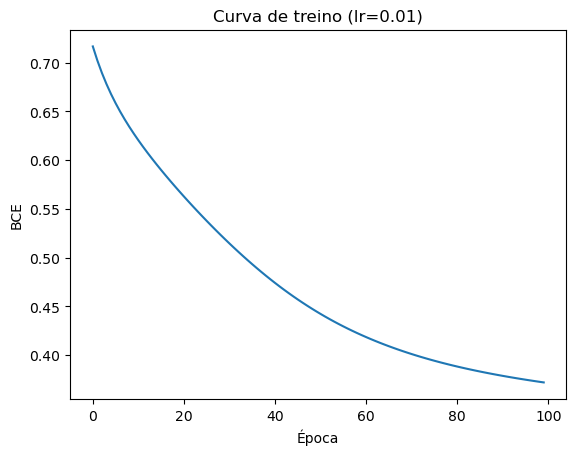

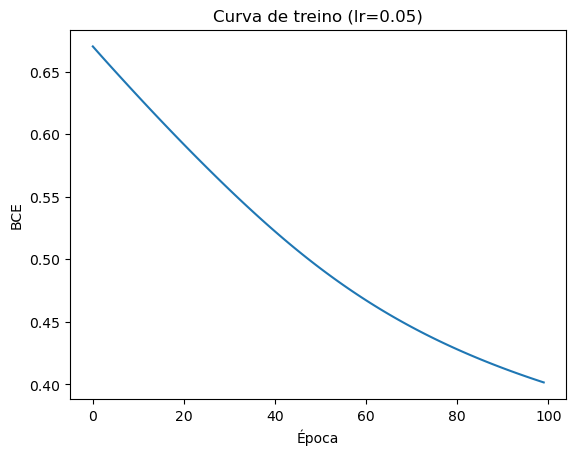

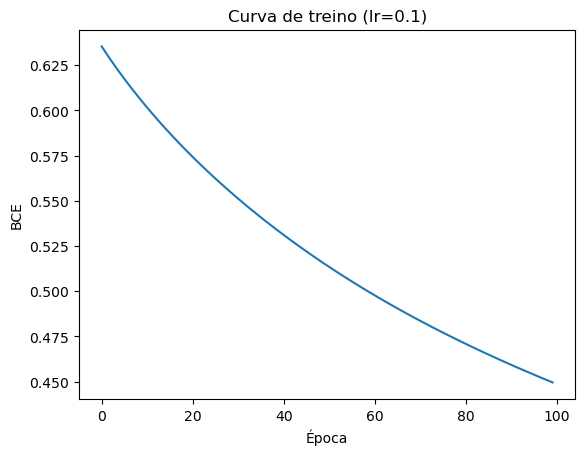

In [20]:
# Treinar com diferentes taxas de aprendizado
import matplotlib.pyplot as plt

for lr in [0.01, 0.05, 0.1]:
    model, losses = train(X, y, n_hidden=8, lr=0.1, epochs=100, verbose=False)
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Época")
    plt.ylabel("BCE")
    plt.title(f"Curva de treino (lr={lr})")
    plt.show()